In [1]:
# Started 12/06 
# Using some work from Saumya's MLP_MNIST notebook
# To-Do:
# * Rebasin MNIST MLP Dataset (format into torch dataloader)
# * Train autoencoder with rebasined dataset
# * Add timing to Git Rebasin to get baseline

# Questions: 
# * Why do the rebasined MLPs not perform the same? They should if permutation is applied correctly. 
# * How does the autoencoder perform?
# * How do the rebasined MLPs 'bounce back' from the rebasin approximation? 

# Goals:
# * Learn what we're doing wrong
# * Get back into the groove

# Ideas: 
# * I think we're doing something wrong with the axes in solving/applying

In [2]:
import os
import torch
from torch import nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.optim import Adam
from collections import defaultdict
import numpy.ma as ma
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from nn.models import DWSModel
from typing import Tuple, NamedTuple
from nn.layers import BN, DWSLayer,InvariantLayer, Dropout, ReLU
from nn.layers.base import BaseLayer,GeneralSetLayer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.backends.cudnn.enabled = False

cpu


In [3]:
# Simple MLP class for MNIST classification

class MLP(nn.Module):
    def __init__(self, init_type='xavier', seed=None):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)
        
        if seed is not None:
            torch.manual_seed(seed)  # Set a unique seed for reproducibility

        self.init_weights(init_type)

    def init_weights(self, init_type):
        if init_type == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
        elif init_type == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        else:
            nn.init.normal_(self.fc1.weight)
            nn.init.normal_(self.fc2.weight)
            nn.init.normal_(self.fc3.weight)
        
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = x.view(-1, 784)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [4]:
# Set up data loader for MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_data = datasets.MNIST('.', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

test_data = datasets.MNIST('.', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

# MLP Stuff:

In [5]:
# MLP management functions: 

def train_mlp(model, epochs=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    
    
def test_mlp(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients for evaluation
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

def save_model_weights(model, save_path):
    # Save actual weights and biases, not just their sizes
    weights = (
        (model.fc1.weight, model.fc2.weight, model.fc3.weight),
        (model.fc1.bias, model.fc2.bias, model.fc3.bias)
    )
    torch.save(weights, save_path)
    
def generate_and_save_clasifiers(N = 10, epochs = 3):
    os.makedirs('models', exist_ok=True)
    for i in range(N):
        seed = i  # Unique seed for each model initialization
        init_type = 'xavier' if i % 2 == 0 else 'he'
        model = MLP(init_type=init_type, seed=seed)

        # Train the model for a few epochs
        train_mlp(model, epochs=epochs)

        # Save the weights and biases as tuples of torch.Size
        save_path = f"models/mlp_weights_{i}.pt"
        save_model_weights(model, save_path)
        print(f"Saved model {i} weights to {save_path}")

        accuracy = test_mlp(model, test_loader)
        print(f"Model {i} Test Accuracy: {accuracy:.2f}%")

# generate_and_save_clasifiers()

In [6]:
# Visualization functions:
def load_and_flatten_weights(model_path):
    weights = torch.load(model_path)
    
    # Flatten the weight and bias sizes
    weight_flat = []
    for w in weights[0]:
        weight_flat.extend(w.view(-1).cpu().detach().numpy())
    
    bias_flat = []
    for b in weights[1]:
        bias_flat.extend(b.view(-1).cpu().detach().numpy())
    
    return np.array(weight_flat + bias_flat)

def plot_saved_weights(N = 10):
    weights_list = []
    for i in range(N):
        model_path = f"models/mlp_weights_{i}.pt"
        weights_list.append(load_and_flatten_weights(model_path))

    # Convert the list into a numpy array (shape: [1000, flattened_size])
    weights_matrix = np.array(weights_list)

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(weights_matrix)

    # Plot the t-SNE results
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], cmap='viridis', alpha = 0.8, s=25)
    plt.title(f"t-SNE Visualization of {N} MLP Weight Configurations")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

# Getting acquainted with functions: 

In [ ]:
N = 1000
epochs = 1
# Note - only two epochs bc right now I'm more interested in volume than quality

generate_and_save_clasifiers(N = N, epochs = epochs)

Saved model 0 weights to models/mlp_weights_0.pt
Model 0 Test Accuracy: 92.25%
Saved model 1 weights to models/mlp_weights_1.pt
Model 1 Test Accuracy: 91.55%
Saved model 2 weights to models/mlp_weights_2.pt
Model 2 Test Accuracy: 91.42%
Saved model 3 weights to models/mlp_weights_3.pt
Model 3 Test Accuracy: 92.35%
Saved model 4 weights to models/mlp_weights_4.pt
Model 4 Test Accuracy: 92.25%
Saved model 5 weights to models/mlp_weights_5.pt
Model 5 Test Accuracy: 91.82%
Saved model 6 weights to models/mlp_weights_6.pt
Model 6 Test Accuracy: 92.30%
Saved model 7 weights to models/mlp_weights_7.pt
Model 7 Test Accuracy: 92.14%
Saved model 8 weights to models/mlp_weights_8.pt
Model 8 Test Accuracy: 92.27%
Saved model 9 weights to models/mlp_weights_9.pt
Model 9 Test Accuracy: 91.75%
Saved model 10 weights to models/mlp_weights_10.pt
Model 10 Test Accuracy: 91.73%
Saved model 11 weights to models/mlp_weights_11.pt
Model 11 Test Accuracy: 91.74%
Saved model 12 weights to models/mlp_weights_1

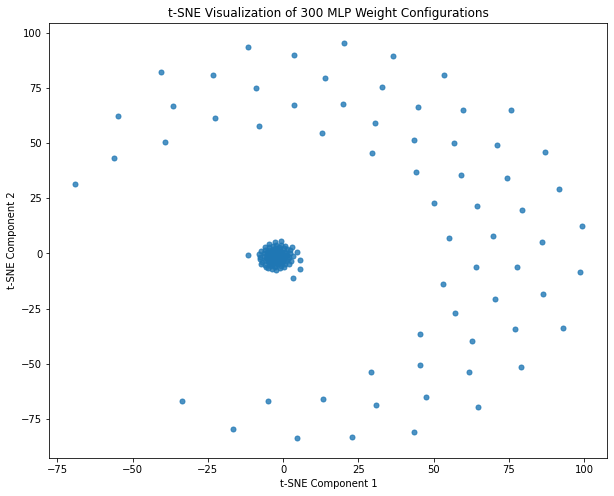

In [7]:
N = 300
plot_saved_weights(N = N)

# GitRebasin Infrastructure: 
* https://github.com/samuela/git-re-basin/blob/main/src/weight_matching.py#L187 

In [8]:
def convert_to_tensor_format(point):
    """Convert tuple-based weights and biases to tensor-based format"""
    weights_tuple, biases_tuple = point[0], point[1]
    permutations = defaultdict(list)
    for i,(layer_weights,layer_biases) in enumerate(zip(weights_tuple,biases_tuple)): 
        permutations["layer_"+str(i+1)+"_weights"] = np.array(layer_weights.detach().cpu())
        permutations["layer_"+str(i+1)+"_biases"] = np.array(layer_biases.detach().cpu())
    return permutations

def apply_permutations(ps, perm, params_b):
    """
    Apply the calculated permutations to params_b.
    
    Args:
        ps: The permutation structure (providing perm_to_axes).
        perm: The computed permutations (output of weight_matching).
        params_b: The parameters to permute.
    
    Returns:
        A new dictionary with permuted `params_b`.
    """
    permuted_params_b = defaultdict(list)

    for param_name, weights in params_b.items():
        permuted_weights = weights.copy()

        for p, axes in ps.perm_to_axes.items():
            for wk, axis in axes:
                if wk == param_name:
                    permuted_weights = np.take(permuted_weights, perm[p], axis=axis)

        # Store the permuted weights
        permuted_params_b[param_name] = permuted_weights

    return permuted_params_b


def weight_matching(rng, ps, params_a, params_b, max_iter=100, init_perm=None, silent=False):
    """
    Find a permutation of `params_b` to make them match `params_a`.

    Args:
        rng: Random number generator.
        ps: A structure that provides permutation mapping (perm_to_axes).
        params_a: Reference parameters (e.g., from a pre-trained model).
        params_b: Parameters to be permuted (e.g., from another model).
        max_iter: Maximum number of iterations for optimization.
        init_perm: Initial permutation, if any.
        silent: If True, suppress logging.
    Returns:
        A dictionary containing the optimal permutations for each layer.
    """
    perm_sizes = {p: params_a[axes[0][0]].shape[axes[0][1]] for p, axes in ps.perm_to_axes.items()}
    
    # Initialize permutations
    perm = {p: np.arange(n) for p, n in perm_sizes.items()} if init_perm is None else init_perm
    perm_names = list(perm.keys())
    
    # Track scores for sanity checks
    best_scores = []

    for iteration in range(max_iter):
        progress = False
        # Shuffle layer processing order for robustness
        for p_ix in rng.permutation(len(perm_names)):
            p = perm_names[p_ix]
            n = perm_sizes[p]
            A = np.zeros((n, n))

            # Accumulate similarity matrices across all axes for layer `p`
            for wk, axis in ps.perm_to_axes[p]:
                w_a = params_a[wk]
                if 'bn' in wk or 'downsample.1' in wk:  # Skip normalization layers
                    w_b = w_a.copy()
                else:
                    # Get permuted version of params_b for current axis
                    w_b = get_permuted_param(ps, perm, wk, params_b, except_axis=axis)

                # Reshape and compute contribution to similarity matrix
                w_a = np.moveaxis(w_a, axis, 0).reshape((n, -1))
                w_b = np.moveaxis(w_b, axis, 0).reshape((n, -1))
                A += w_a @ w_b.T

            # Solve assignment problem to find the best permutation
            ri, ci = linear_sum_assignment(A, maximize=True)
            assert (ri == np.arange(len(ri))).all()  # Sanity check

            # Compute alignment scores before and after permutation
            oldL = np.vdot(A, np.eye(n)[perm[p]])
            newL = np.vdot(A, np.eye(n)[ci, :])
#             if not silent:
#                 print(f"Iteration {iteration} - Layer {p}: Score improvement {newL - oldL:.6f}")

            # Update permutation if there is an improvement
            progress = progress or newL > oldL + 1e-12
            perm[p] = np.array(ci)

        # Exit if no improvement is observed
        if not progress:
            best_scores.append(oldL)
            break
            
    return perm, best_scores


In [14]:
# Fresh from GitRebasin GitHub:
# Not really sure how this all fits together, need to look closer at it 

from collections import defaultdict
from typing import NamedTuple
import jax.numpy as jnp
from jax import random
from scipy.optimize import linear_sum_assignment


class PermutationSpec(NamedTuple):
    perm_to_axes: dict
    axes_to_perm: dict

def mlp_permutation_spec(num_hidden_layers: int) -> PermutationSpec:
    """We assume that one permutation cannot appear in two axes of the same weight array."""
    assert num_hidden_layers >= 1
    return permutation_spec_from_axes_to_perm({
            "Dense_0/kernel": (None, "P_0"),
            **{f"Dense_{i}/kernel": (f"P_{i-1}", f"P_{i}")
             for i in range(1, num_hidden_layers)},
            **{f"Dense_{i}/bias": (f"P_{i}", )
             for i in range(num_hidden_layers)},
            f"Dense_{num_hidden_layers}/kernel": (f"P_{num_hidden_layers-1}", None),
            f"Dense_{num_hidden_layers}/bias": (None, ),
            })

def permutation_spec_from_axes_to_perm(axes_to_perm: dict) -> PermutationSpec:
    perm_to_axes = defaultdict(list)
    for wk, axis_perms in axes_to_perm.items():
        for axis, perm in enumerate(axis_perms):
            if perm is not None:
                perm_to_axes[perm].append((wk, axis))
    return PermutationSpec(perm_to_axes=dict(perm_to_axes), axes_to_perm=axes_to_perm)


# -----

In [15]:
# Define a mock permutation structure
class PermStructure:
    def __init__(self, perm_to_axes):
        self.perm_to_axes = perm_to_axes

# Define `get_permuted_param` function
def get_permuted_param(ps, perm, param_name, params, except_axis):
    """
    Get permuted parameter based on current permutations.
    """
    w = params[param_name]
    for p, axes in ps.perm_to_axes.items():
        for wk, axis in axes:
            if wk == param_name and axis != except_axis:
                w = np.take(w, perm[p], axis=axis)
    return w

# Define permutation mapping (example for 3 layers) -  A MESS 
perm_to_axes = {
    # idea - lay out the two valid options to search
    "layer_1": [("layer_1_weights", 0)],
    "layer_2": [("layer_2_weights", 1)],
    "layer_3": [("layer_3_weights", 0)],
    
    "layer_1": [("layer_1_weights", 1)],
    "layer_2": [("layer_2_weights", 0)],
    "layer_3": [("layer_3_weights", 1)],
}

ps = PermStructure(perm_to_axes)

rng = np.random.default_rng(42)

# Apply and Visualize Rebasin:

In [16]:
def flatten_and_concatenate(params):
    """Flatten the weights and biases for each layer and concatenate them."""
    flattened_params = []
    for layer in list(params.keys()):
        if 'weights' in layer:
            # Flatten the weights
            layer_weights = np.array(params[layer]).flatten()
            flattened_params.append(layer_weights)
        elif 'biases' in layer:
            # Flatten the biases
            layer_biases = np.array(params[layer]).flatten()
            flattened_params.append(layer_biases)
    
    # Return a single concatenated vector for all layers in the dictionary
    return np.concatenate(flattened_params)

def plot_tsne(reference_param, permuted_params_list, data_point_params):
    """Plot t-SNE of weights and biases from the reference_param, permuted_params_list, and data_points."""
    
    # Flatten and concatenate the reference parameter (ref_point)
    flattened_reference = flatten_and_concatenate(reference_param)
        
    # Initialize the list of flattened params for all permuted parameters
    all_params = [flattened_reference]
    
    # Flatten and concatenate all permuted parameters
    for permuted_params in permuted_params_list:
        flattened_permuted_param = flatten_and_concatenate(permuted_params)
        all_params.append(flattened_permuted_param)
    
    # Flatten and concatenate all data points
    for data in data_point_params:
        flattened_data = flatten_and_concatenate(data)
        all_params.append(flattened_data)
    
    # Perform t-SNE to reduce the dimensions to 2D
    tsne = TSNE(n_components=2, random_state=42, perplexity=2)
    tsne_results = tsne.fit_transform(np.vstack(all_params))
    
    # Plot the t-SNE results
    plt.figure(figsize=(12, 8))
    
    # Plot the permuted parameters
    for i, tsne_result in enumerate(tsne_results[1:len(permuted_params_list)+1], 1):
        if i == 1:
            plt.scatter(tsne_result[0], tsne_result[1], label=f'Permuted Params', color='green')
        else:
            plt.scatter(tsne_result[0], tsne_result[1], color='green')
    
    # Plot the original data points
    for i, tsne_result in enumerate(tsne_results[len(permuted_params_list)+1:], 1):
        if i == 1:
            plt.scatter(tsne_result[0], tsne_result[1], label=f'Original Params', color='blue')
        else:
            plt.scatter(tsne_result[0], tsne_result[1], color='blue')
                    
    # Plot reference point
    plt.scatter(tsne_results[0, 0], tsne_results[0, 1], label='Reference (ref_point)', color='red', marker='X')
    
    # Add titles and labels
    plt.title("t-SNE visualization of weights and biases for 1 reference parameter, permuted params, and data points")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    
    # Show plot
    plt.show()

In [17]:
# Call weight_matching function
# N = 10
ref_point = torch.load('models/mlp_weights_0.pt')
ref_data_param = convert_to_tensor_format(ref_point)

permuted_params = []
data_point_params = []
scores = []
for i in range(1, N):
    model_path = f"models/mlp_weights_{i}.pt"
    data = torch.load(model_path)
    data_params = convert_to_tensor_format(data)
    permutations, best_scores = weight_matching(rng, ps, ref_data_param, data_params)
    permuted_param = apply_permutations(ps, permutations, data_params)
    scores.append(best_scores)
    permuted_params.append(permuted_param)
    data_point_params.append(data_params)

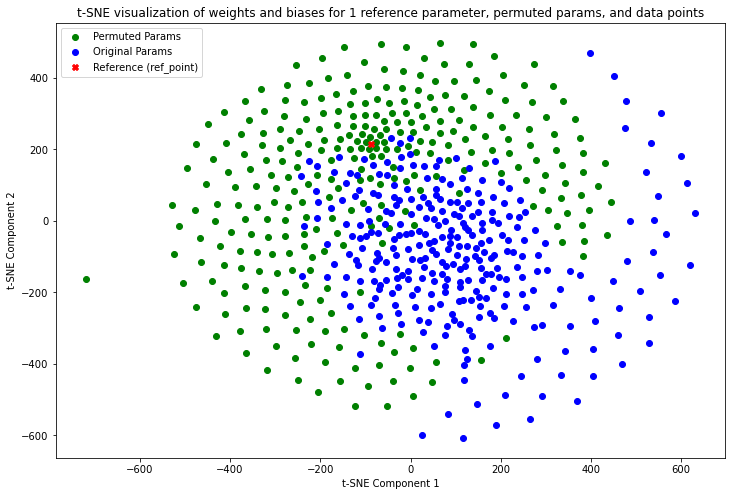

In [18]:
plot_tsne(ref_data_param, permuted_params, data_point_params)

In [19]:
# list( scores )

In [20]:
def get_rebasined_accuracies(permuted_params = permuted_params, num_layers = 3):
    accuracy_list = []
    k = len(permuted_params)
    for j in range(k):
        mlp = MLP()
        weights_list = []
        biases_list = []


        # Sort layers by their numeric indices to maintain the correct order
        num_layers = 3
        for i in range(1, num_layers + 1):
            weights_key = f"layer_{i}_weights"
            biases_key = f"layer_{i}_biases"

            if weights_key in permuted_params[j] and biases_key in permuted_params[j]:
                weights_list.append(torch.tensor(permuted_params[j][weights_key]))
                biases_list.append(torch.tensor(permuted_params[j][biases_key]))

        mlp.fc1.weight.data = weights_list[0]
        mlp.fc1.bias.data = biases_list[0]

        mlp.fc2.weight.data = weights_list[1]
        mlp.fc2.bias.data = biases_list[1]

        mlp.fc3.weight.data = weights_list[2]
        mlp.fc3.bias.data = biases_list[2]
        accuracy = test_mlp(mlp, test_loader)
        
        accuracy_list.append(accuracy)
    
    return accuracy_list
    

In [17]:
# Accuracy of rebasined MLPs on the test loader
rebasined_accuracies = get_rebasined_accuracies(permuted_params = permuted_params)
rebasined_accuracies

[13.45,
 12.2,
 9.83,
 8.9,
 19.74,
 9.0,
 8.73,
 15.78,
 11.31,
 8.37,
 10.25,
 11.11,
 14.48,
 10.98,
 13.25,
 9.36,
 9.69,
 22.12,
 15.24,
 9.94,
 3.0,
 21.33,
 10.23,
 9.4,
 11.62,
 21.86,
 11.32,
 13.51,
 10.92,
 14.75,
 12.36,
 12.24,
 8.12,
 13.6,
 14.4,
 14.76,
 9.32,
 12.37,
 9.19,
 10.12,
 7.91,
 22.03,
 10.96,
 17.64,
 21.97,
 11.59,
 14.43,
 10.36,
 11.39,
 10.99,
 8.02,
 10.1,
 16.2,
 12.9,
 10.93,
 18.1,
 12.4,
 12.26,
 12.11,
 10.12,
 8.88,
 14.49,
 8.12,
 10.9,
 10.09,
 9.31,
 14.34,
 9.61,
 17.17,
 8.98,
 9.92,
 13.48,
 13.2,
 16.33,
 8.46,
 9.96,
 9.88,
 10.2,
 12.97,
 12.14,
 13.57,
 17.51,
 5.12,
 16.37,
 10.5,
 11.14,
 10.27,
 15.49,
 10.92,
 17.09,
 11.38,
 11.94,
 10.01,
 12.27,
 10.26,
 10.36,
 10.39,
 10.02,
 10.1,
 9.84,
 10.63,
 10.01,
 11.55,
 17.42,
 11.34,
 9.62,
 11.36,
 18.84,
 12.01,
 12.14,
 8.5,
 9.49,
 10.01,
 12.48,
 15.61,
 12.91,
 7.62,
 18.28,
 9.27,
 15.76,
 11.66,
 15.09,
 11.07,
 2.49,
 11.46,
 8.43,
 17.61,
 10.53,
 17.0,
 8.69,
 12.38,
 16.1

In [18]:
# Accuracy of the original MLPs on the test loader
original_accuracies = get_rebasined_accuracies(permuted_params = data_point_params)
original_accuracies

[91.55,
 91.42,
 92.35,
 92.25,
 91.82,
 92.3,
 92.14,
 92.27,
 91.75,
 91.73,
 91.74,
 91.46,
 91.13,
 92.8,
 91.14,
 92.6,
 92.51,
 92.01,
 91.31,
 91.65,
 92.13,
 91.93,
 91.27,
 92.34,
 91.99,
 92.04,
 91.76,
 92.07,
 91.69,
 92.48,
 91.66,
 92.51,
 92.73,
 91.25,
 91.81,
 91.77,
 92.11,
 91.34,
 91.55,
 90.8,
 91.94,
 91.46,
 92.44,
 92.2,
 92.04,
 91.01,
 89.77,
 92.17,
 91.66,
 92.02,
 91.84,
 92.42,
 92.25,
 91.01,
 91.79,
 91.13,
 92.21,
 92.61,
 91.53,
 91.74,
 92.05,
 91.95,
 90.55,
 92.04,
 90.76,
 91.41,
 91.97,
 91.27,
 92.29,
 92.8,
 92.13,
 91.37,
 91.11,
 92.02,
 91.63,
 92.93,
 92.04,
 91.79,
 92.31,
 92.26,
 91.83,
 92.08,
 90.5,
 92.25,
 91.64,
 91.25,
 91.32,
 91.89,
 91.5,
 92.7,
 90.77,
 91.97,
 92.31,
 92.86,
 92.24,
 91.85,
 90.03,
 91.97,
 91.6,
 92.23,
 91.94,
 92.42,
 90.85,
 91.91,
 91.76,
 92.0,
 92.0,
 92.23,
 91.57,
 92.14,
 91.51,
 90.97,
 91.72,
 91.89,
 92.01,
 91.13,
 91.85,
 92.01,
 91.76,
 92.1,
 91.8,
 92.56,
 90.25,
 92.16,
 91.62,
 90.04,
 91.84

In [19]:
# The best GitRebasin Score of each MLP in weight matching
scores

[[14.965052381157875],
 [10.509342715144157],
 [16.566588133573532],
 [10.755921520292759],
 [11.915596321225166],
 [10.958784222602844],
 [12.023768678307533],
 [40.928946069441736],
 [11.951416477560997],
 [41.80377604998648],
 [15.756578549742699],
 [41.77920494787395],
 [11.470073860138655],
 [10.572496831417084],
 [41.09456169605255],
 [11.937598437070847],
 [40.92321027070284],
 [40.95337100699544],
 [16.587440833449364],
 [11.824529230594635],
 [16.356323532760143],
 [11.26022769510746],
 [16.294567421078682],
 [11.93487723916769],
 [11.502146765589714],
 [11.939457014203072],
 [11.47074519842863],
 [11.054157823324203],
 [16.873759478330612],
 [10.457245521247387],
 [40.255638061091304],
 [10.810062140226364],
 [11.117495104670525],
 [11.20389561355114],
 [16.60659635066986],
 [11.237262427806854],
 [41.37933616153896],
 [10.628608912229538],
 [40.93685860559344],
 [40.35485393553972],
 [16.656104043126106],
 [41.018085496500134],
 [40.224101008847356],
 [41.81411681883037],
 [

Text(0.5, 1.0, 'Clustering Sanity Check')

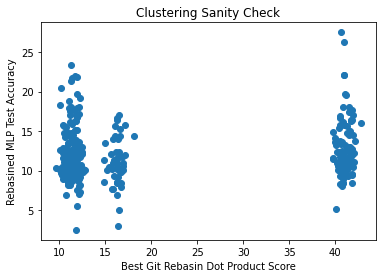

In [21]:
plt.scatter(scores, rebasined_accuracies)
plt.xlabel(f"Best Git Rebasin Dot Product Score")
plt.ylabel(f"Rebasined MLP Test Accuracy")
plt.title(f"Clustering Sanity Check")

In [ ]:
# permuted_params[0].keys()
# permuted_params[0]['layer_1_biases'], data_point_params[0]['layer_1_biases']
np.sum( permuted_params[0]['layer_1_biases'] ), np.sum( data_point_params[0]['layer_1_biases'] )

In [ ]:
# data_point_params[0].keys()
# permuted_params[0]['layer_1_weights'], data_point_params[0]['layer_1_weights']
np.sum( permuted_params[0]['layer_1_weights'] ), np.sum( data_point_params[0]['layer_1_weights'] )

# Question: Do we even need to rebasin? 

In [38]:
from typing import NamedTuple, Tuple, Union

class Batch(NamedTuple):
    weights: Tuple
    biases: Tuple

    def _assert_same_len(self):
        assert len(set([len(t) for t in self])) == 1

    def as_dict(self):
        return self._asdict()

    def to(self, device):
        """move batch to device"""
        return self.__class__(
            weights=tuple(w.to(device) for w in self.weights),
            biases=tuple(w.to(device) for w in self.biases),        )

    def __len__(self):
        return len(self.weights[0])


class MLPDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        """Initialize the dataset with data.
        
        Args:
            data (list): List of permuted parameters for dataset.
        """
        self.data_points = data  # Store the data points

    def tensors_to_tuples(self, permutations):
        """
        Convert tensor-based format back to tuple-based weights and biases.

        Args:
            permutations (dict): Dictionary containing tensor-based weights and biases.

        Returns:
            tuple: A tuple of (weights_tuple, biases_tuple).
        """
        weights_list = []
        biases_list = []

        # Sort layers by their numeric indices to maintain the correct order
        num_layers = len(permutations) // 2
        for i in range(1, num_layers + 1):
            weights_key = f"layer_{i}_weights"
            biases_key = f"layer_{i}_biases"

            if weights_key in permutations and biases_key in permutations:
                weights_list.append(torch.tensor(permutations[weights_key]).permute(1,0).unsqueeze(-1))
                biases_list.append(torch.tensor(permutations[biases_key]).unsqueeze(-1))

        # Convert lists back to tuples
        weights_tuple = tuple(weights_list)
        biases_tuple = tuple(biases_list)

        return (weights_tuple, biases_tuple)
    
    def __len__(self):
        """Returns the total number of data points in the dataset."""
        return len(self.data_points)
    
    def __getitem__(self, item):
        """Fetch a data point and convert it to Batch format."""
        # Get the permuted data point (weights, biases) for the given index
        points = self.data_points[item]  # Assuming data_points is a list of permuted parameters

        # Convert tensors in the permuted data point to tuple format
        weights, biases = self.tensors_to_tuples(points)
        return Batch(weights, biases=biases)
    


In [39]:
# permuted_params.append(ref_data_param)
mlp_data = MLPDataset(data_point_params) # original MLPs

# Use DataLoader to load the data in batches
mlp_loader = torch.utils.data.DataLoader(
    dataset=mlp_data,
    batch_size=4,  # Adjust batch size as needed
    shuffle=True,  # Shuffle the dataset
    pin_memory=True,  # Optional: speeds up data transfer to GPU
)


rebasined_data = MLPDataset(permuted_params)

# Use DataLoader to load the data in batches
rebasined_loader = torch.utils.data.DataLoader(
    dataset=rebasined_data,
    batch_size=4,  # Adjust batch size as needed
    shuffle=True,  # Shuffle the dataset
    pin_memory=True,  # Optional: speeds up data transfer to GPU
)

# del data_point_params

In [40]:
class DWSEncoder(BaseLayer):
    def __init__(
       self,
        weight_shapes,
        bias_shapes,
        input_features,
        hidden_dims,
        downsample_dim,
        n_hidden=2,
        reduction="max",
        bias=True,
        n_fc_layers=1,
        num_heads=4,
        set_layer="sab",
        add_layer_skip=False,
        input_dim_downsample=None,
        init_scale=1.,
        init_off_diag_scale_penalty=1.,
        bn=False,
        dropout_rate = 0.001,
        diagonal=False,
    ):
        super().__init__(
            in_features=input_features,
            out_features=hidden_dims,
            bias=bias,
            reduction=reduction,
            n_fc_layers=n_fc_layers,
            num_heads=num_heads,
            set_layer=set_layer,
        )

        self.downsample_dim = downsample_dim
        self.bias = bias
        self.n_fc_layers = n_fc_layers
        self.num_heads = num_heads
        
#         self.skip = self._get_mlp(
#             in_features=input_features,
#             out_features=input_features,
#             bias=bias,
#         )
        
        self.InitialLayer = DWSModel(
            weight_shapes=weight_shapes,
            bias_shapes=bias_shapes,
            input_features=input_features,
            hidden_dim=hidden_dims,
            n_hidden=n_hidden,
            reduction=reduction,
            bias=bias,
            output_features=input_features,
            n_fc_layers=n_fc_layers,
            num_heads=num_heads,
            set_layer=set_layer,
            dropout_rate=dropout_rate,
            input_dim_downsample=input_dim_downsample,
            init_scale=init_scale,
            init_off_diag_scale_penalty=init_off_diag_scale_penalty,
            bn=bn,
            add_skip=False,
            add_layer_skip=add_layer_skip,
            diagonal=diagonal,
        )   

    def downsample_input_weights(self, inputs, downsample_dim):
        """Downsample the input weights to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first weight dimension [32,2,32,1] -> [32,2,8,1]
        inputs[0] = self._downsample_weight(inputs[0], dim=2, downsample_dim = downsample_dim)
        # Downsample second weight dimension [32,32,32,1] -> [32,8,8,1]
        inputs[1] = self._downsample_weight(inputs[1], dim=1, downsample_dim = downsample_dim)
        inputs[1] = self._downsample_weight(inputs[1], dim=2, downsample_dim = downsample_dim)

        # Downsample third weight dimension [32,32,1,1] -> [32,8,1,1]
        inputs[2] = self._downsample_weight(inputs[2], dim=1, downsample_dim = downsample_dim)

        return tuple(inputs)

    def downsample_input_biases(self, inputs, downsample_dim):
        """Downsample the input biases to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first bias dimension [32,32,1] -> [32,8,1]
        inputs[0] = self._downsample_bias(inputs[0], downsample_dim= downsample_dim)

        # Downsample second bias dimension [32,32,1] -> [32,8,1]
        inputs[1] = self._downsample_bias(inputs[1], downsample_dim = downsample_dim)

        return tuple(inputs)
    
    def batchNormLayer(self,weights, biases):
        relu = nn.ReLU()
        weights = tuple(relu(nn.BatchNorm2d(w.shape[1]).to(device)(w)) for w in weights)
        biases = tuple(relu(nn.BatchNorm1d(b.shape[1]).to(device)(b.squeeze(-1)).unsqueeze(-1)) for b in biases)
        return weights, biases

    def forward(self, x: Tuple[Tuple[torch.tensor], Tuple[torch.tensor]]):
        """Forward pass through the encoder."""
        x = self.InitialLayer(x)
        weights = self.downsample_input_weights(x[0], 16)
        biases = self.downsample_input_biases(x[1], 16)
        weights, biases = self.batchNormLayer( weights, biases)
        weights = self.downsample_input_weights(weights, self.downsample_dim)
        biases = self.downsample_input_biases(biases, self.downsample_dim)
        out = (weights, biases)
        return out

    def _downsample_weight(self, weight, dim,downsample_dim):
        d0 = weight.shape[dim]
        down_sample = GeneralSetLayer(
            in_features=d0,
            out_features= downsample_dim,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        wi = weight.permute(0, 3, 1, 2) if dim == 2 else weight.permute(0, 3, 2, 1)
        wi = down_sample(wi)
        return wi.permute(0, 2, 3, 1) if dim == 2 else wi.permute(0, 3, 2, 1)

    def _downsample_bias(self, bias, downsample_dim):
        d0 = bias.shape[1]
        down_sample = GeneralSetLayer(
            in_features=d0,
            out_features=downsample_dim,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        wi = bias.permute(0, 2, 1)
        wi = down_sample(wi)
        return wi.permute(0, 2, 1)

In [41]:
class Decoder(nn.Module,
             ):
    def __init__(self, upsample_dim,
                weight_shapes,
                bias_shapes,
                input_features,
                hidden_dims,
                downsample_dim,
                n_hidden=2,
                reduction="max",
                set_layer="sab",
                add_layer_skip=False,
                input_dim_downsample=None,
                init_scale=1.,
                init_off_diag_scale_penalty=1.,
                bn=False,
                dropout_rate = 0.001,
                diagonal=False,
                 bias=True,
                 n_fc_layers=1,
                 num_heads=4):
        
        super(Decoder, self).__init__()
        
        self.upsample_dim = upsample_dim
        self.bias = bias
        self.n_fc_layers = n_fc_layers
        self.num_heads = num_heads
        
        self.InitialLayer = DWSModel(
            weight_shapes= weight_shapes,
            bias_shapes= bias_shapes,
            input_features=input_features,
            hidden_dim=hidden_dims,
            n_hidden=n_hidden,
            reduction=reduction,
            bias=bias,
            output_features=input_features,
            n_fc_layers=n_fc_layers,
            num_heads=num_heads,
            set_layer=set_layer,
            dropout_rate=dropout_rate,
            input_dim_downsample=input_dim_downsample,
            init_scale=init_scale,
            init_off_diag_scale_penalty=init_off_diag_scale_penalty,
            bn=bn,
            add_skip=False,
            add_layer_skip=add_layer_skip,
            diagonal=diagonal,
        )   
        
    def upsample_input_weights(self, inputs):
        """Upsample the input weights to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first weight dimension [32,2,8,1] -> [32,2,32,1]
        inputs[0] = self._upsample_weight(inputs[0], dim=2 , index = 0)

        # Downsample second weight dimension [32,8,8,1] -> [32,32,32,1]
        inputs[1] = self._upsample_weight(inputs[1], dim=1, index = 1)
        inputs[1] = self._upsample_weight(inputs[1], dim=2, index = 1)


        # Downsample third weight dimension [32,8,1,1] -> [32,32,1,1]
        inputs[2] = self._upsample_weight(inputs[2], dim=1, index = 2)

        return tuple(inputs)

    def upsample_input_biases(self, inputs):
        """Upsample the input biases to the specified dimensions."""
        inputs = list(inputs)

        # Downsample first bias dimension [32,8,1] -> [32,32,1]
        inputs[0] = self._upsample_bias(inputs[0], index = 0)

        # Downsample second bias dimension [32,8,1] -> [32,32,1]
        inputs[1] = self._upsample_bias(inputs[1], index = 1)

        return tuple(inputs)
    
    def _upsample_weight(self, weight, dim, index):
        d0 = weight.shape[dim]
        up_sample = GeneralSetLayer(
            in_features=d0,
            out_features=self.upsample_dim,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        wi = weight.permute(0, 3, 1, 2) if dim == 2 else weight.permute(0, 3, 2, 1)
        wi = up_sample(wi)
        wi = wi.permute(0, 2, 3, 1) if dim == 2 else wi.permute(0, 3, 2, 1)
        return wi 

    def _upsample_bias(self, bias, index):
        d0 = bias.shape[1]
        up_sample = GeneralSetLayer(
            in_features=d0,
            out_features=self.upsample_dim,
            reduction="attn",
            bias=self.bias,
            n_fc_layers=self.n_fc_layers,
            num_heads=self.num_heads,
            set_layer="ds",
        ).to(device)
        
        bi = bias.permute(0, 2, 1)
        bi = up_sample(bi)
        bi = bi.permute(0, 2, 1)
        return bi


    def forward(self, x):
        # Decode weight tensors
        weight_space = self.upsample_input_weights(x[0])
        bias_space = self.upsample_input_biases(x[1])

        output = self.InitialLayer((weight_space , bias_space))
        return output

In [55]:
# Our AutoEncoder using DWSModel
class AutoEncoder(nn.Module):
    def __init__(self,
            input_features,
            weight_shapes,
            bias_shapes,
            hidden_dims,
            downsample_dim,
            n_hidden=2,
            reduction = "attn",
            input_dim_downsample=None,
            bn = False,
    ):
        super().__init__()
        self.encoder = DWSEncoder(weight_shapes=weight_shapes,
                                bias_shapes=bias_shapes,
                                input_features=input_features,
                                hidden_dims=hidden_dims,
                                downsample_dim = downsample_dim,
                                n_hidden=n_hidden,
                                reduction= reduction,
                                bn=bn).to(device)
        self.decoder = Decoder(32,
                               weight_shapes,
                               bias_shapes,
                               input_features,
                               hidden_dims,
                               downsample_dim,).to(device)
        
    def forward(self,inputs):
        encoded_data = self.encoder(inputs)
        output = self.decoder(encoded_data)
        return encoded_data, output

In [63]:
class TupleLoss(nn.Module):
    def __init__(self):
        super(TupleLoss, self).__init__()
        self.mse_loss = torch.nn.MSELoss()

    def forward(self, output, target):
        weights1, biases1 = output
        weights2, biases2 = target

        # Compute MSE for weights
        weight_loss = sum(
            self.mse_loss(w1.flatten(), w2.flatten()) for w1, w2 in zip(weights1, weights2)
        ) / len(weights1)

        # Compute MSE for biases
        bias_loss = sum(
            self.mse_loss(b1.flatten(), b2.flatten()) for b1, b2 in zip(biases1, biases2)
        ) / len(biases1)

        # Combine the losses
        total_loss = 0.5 * weight_loss + 0.5 * bias_loss

        return total_loss

    
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss = 0.0
    total = 0.0
    criterion = TupleLoss()
    for batch in loader:
        batch = batch.to(device)
        inputs = (batch.weights, batch.biases)
        _ ,out = model(inputs)
        loss += criterion(out, inputs)
        total += 1

    model.train()
    avg_loss = loss / total

    return avg_loss


import logging
import torch
from tqdm import trange
from torch.cuda.amp import GradScaler, autocast

def train_model(model, train_loader):
    learning_rate = 1e-3
    num_epochs = 1
    accumulation_steps = 4  # Number of steps to accumulate gradients
    criterion = TupleLoss()
    epoch_iter = trange(num_epochs)
    epoch_loss = -1
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=5)
    previous_epoch_loss = 1000

    for epoch in epoch_iter:
        total_loss = 0
        counter = 0
        
        optimizer.zero_grad()  # Initialize optimizer's gradients at the start of each epoch
        
        for i, batch in enumerate(train_loader):
            model.train() 
            
            batch = batch.to(device)
            inputs = (batch.weights, batch.biases)
            
            _, out = model(inputs)

            loss = criterion(out, inputs)/accumulation_steps

            del out, inputs, batch
            torch.cuda.empty_cache()  # Clear memory
            
            loss.backward() 
            
            total_loss += loss.item() * accumulation_steps  # Scale back accumulated loss
            counter += 1
            
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()                        
                epoch_loss = total_loss / counter
                epoch_iter.set_description(
                    f"[{epoch} {i+1}], train loss: {loss.item():.5f}, epoch loss: {epoch_loss:.5f}"
                )
                total_loss = 0
                counter = 0
            

        scheduler.step(epoch_loss)
            
#         if epoch_loss < previous_epoch_loss:
#             model_path = f"Outputs/model_MLP_REBASIN.pth"
#             torch.save(model.state_dict(), model_path)
#             previous_epoch_loss = epoch_loss
            
#         if (epoch + 1) % 25 == 0:
#              print(evaluate(model, test_loader))

    print("Training complete!")


In [65]:
# MLP weight shapes:
weight_shapes = tuple(w.shape[:2] for w in mlp_data[0][0])
bias_shapes = tuple(b.shape[:1] for b in mlp_data[0][1])
print(weight_shapes, bias_shapes)


(torch.Size([784, 32]), torch.Size([32, 32]), torch.Size([32, 10])) (torch.Size([32]), torch.Size([32]), torch.Size([10]))


In [66]:
mlp_model = AutoEncoder(
    input_features = 1,
    weight_shapes = weight_shapes, 
    bias_shapes = bias_shapes,
    downsample_dim = 8,
    hidden_dims = 8,
    reduction = "max",
    n_hidden= 2,
    bn=True,
).to(device)

train_model(mlp_model, mlp_loader)

[0 75], train loss: 87871.36719, epoch loss: 343929.94792: 100%|██████████| 1/1 [16:31<00:00, 991.79s/it]


Training complete!


In [67]:
weight_shapes = tuple(w.shape[:2] for w in rebasined_data[0][0])
bias_shapes = tuple(b.shape[:1] for b in rebasined_data[0][1])
print(weight_shapes, bias_shapes)

(torch.Size([784, 32]), torch.Size([32, 32]), torch.Size([32, 10])) (torch.Size([32]), torch.Size([32]), torch.Size([10]))


In [68]:
rebasined_model = AutoEncoder(
    input_features=1,
    weight_shapes = weight_shapes, 
    bias_shapes = bias_shapes,
    downsample_dim = 8,
    hidden_dims=8,
    reduction = "max",
    n_hidden=2,
    bn=True,
).to(device)

train_model(rebasined_model, rebasined_loader)

[0 75], train loss: 553.85199, epoch loss: 3607.43835: 100%|██████████| 1/1 [16:44<00:00, 1004.67s/it]


Training complete!
